In [1]:
import os
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython import display

from tensorflow.keras import layers
from tensorflow.keras import models

import seaborn as sns

In [2]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
tf.keras.utils.set_random_seed(seed)

In [3]:
data_dir = "speech commands"

In [4]:
commands = np.array(os.listdir(data_dir))
print(commands)

['down' 'go' 'left' 'right' 'stop' 'up']


In [5]:
filenames_pattern = data_dir + '/*/*'
filenames = glob.glob(filenames_pattern, recursive=True)

In [6]:
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of samples: ', num_samples)
print('Number of samples per class: ', num_samples//len(commands))
print('Examples of sample: ', filenames[0])

Number of samples:  6000
Number of samples per class:  1000
Examples of sample:  tf.Tensor(b'speech commands\\stop\\b5d1e505_nohash_0.wav', shape=(), dtype=string)


In [7]:
train_files = filenames[:4800]
val_files = filenames[4800: 4800 + 600]
test_files = filenames[-600:]

print('Train size:', len(train_files))
print('Validation size:', len(val_files))
print('Test size:', len(test_files))

Train size: 4800
Validation size: 600
Test size: 600


In [8]:
test_file = tf.io.read_file(filenames[0])
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([16000, 1])

In [9]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(contents=audio_binary)
    return tf.squeeze(audio, axis=-1)

In [10]:
decode_audio(test_file)

<tf.Tensor: shape=(16000,), dtype=float32, numpy=
array([-3.0517578e-05,  0.0000000e+00, -3.0517578e-05, ...,
        0.0000000e+00,  0.0000000e+00, -6.1035156e-05], dtype=float32)>

In [11]:
def get_label(file_path):
    parts = tf.strings.split(
    input=file_path,
    sep=os.path.sep)
    return parts[-2]

In [12]:
get_label(filenames[0])

<tf.Tensor: shape=(), dtype=string, numpy=b'stop'>

In [13]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

In [14]:
get_waveform_and_label(filenames[0])

(<tf.Tensor: shape=(16000,), dtype=float32, numpy=
 array([-3.0517578e-05,  0.0000000e+00, -3.0517578e-05, ...,
         0.0000000e+00,  0.0000000e+00, -6.1035156e-05], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'stop'>)

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

In [16]:
waveform_ds = files_ds.map(
    map_func = get_waveform_and_label,
    num_parallel_calls=AUTOTUNE
)

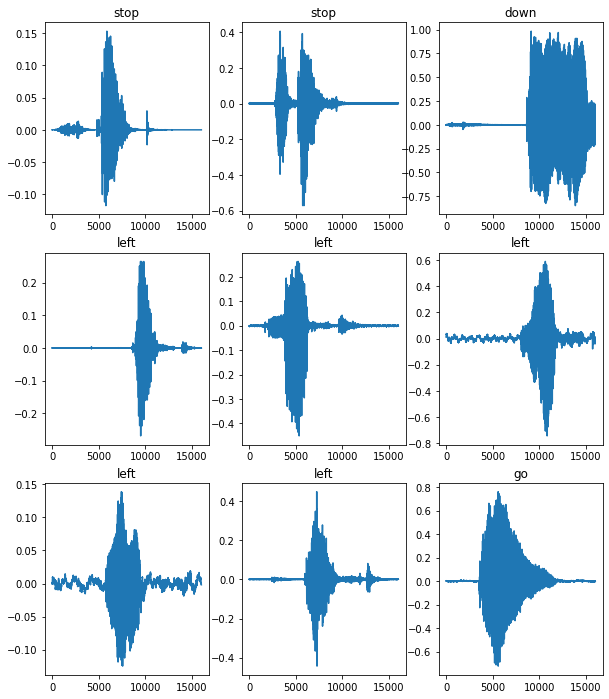

In [17]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.savefig('waveform_plot.jpeg')
plt.show()

In [18]:
def get_spectrogram(waveform):
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
        [input_len] - tf.shape(waveform),
        dtype=tf.float32)
    waveform = tf.cast(waveform, dtype=tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(
        equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [19]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: stop
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [20]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

<ipython-input-20-2564ff6a66d7>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


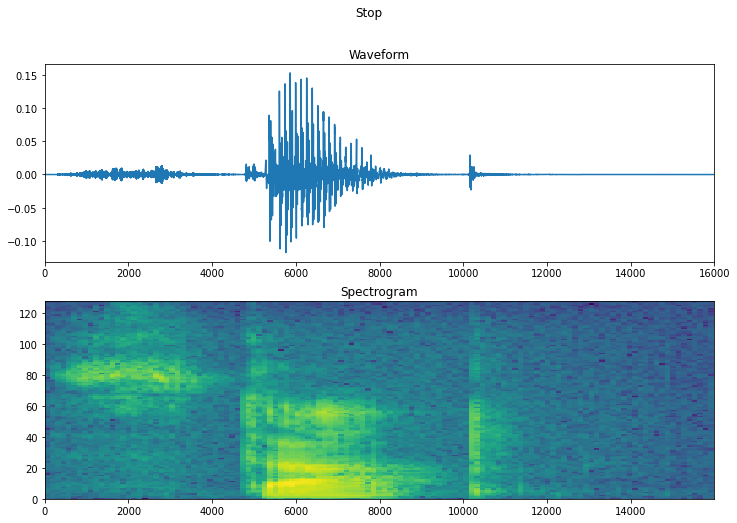

In [21]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')

fig.suptitle(label.capitalize())

plt.savefig('waveform_and_spectrogram.jpeg')
plt.show()

In [22]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id

In [23]:
spectrogram_ds = waveform_ds.map(
    map_func=get_spectrogram_and_label_id,
    num_parallel_calls=AUTOTUNE)


<ipython-input-20-2564ff6a66d7>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


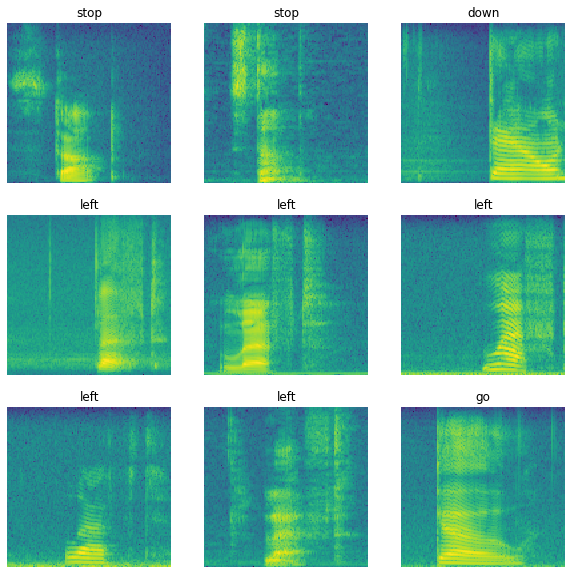

In [24]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')
plt.savefig('spectrogram_plot.jpeg')
plt.show()

In [25]:
def preprocess_dataset(files):
    print(files)
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    print(files_ds)
    output_ds = files_ds.map(
        map_func=get_waveform_and_label,
        num_parallel_calls=AUTOTUNE)
    print(output_ds)
    output_ds = output_ds.map(
        map_func=get_spectrogram_and_label_id,
        num_parallel_calls=AUTOTUNE)
    print(output_ds)
    return output_ds

In [26]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

tf.Tensor(
[b'speech commands\\go\\26b28ea7_nohash_2.wav'
 b'speech commands\\left\\07ad9b59_nohash_0.wav'
 b'speech commands\\right\\3bfd30e6_nohash_4.wav'
 b'speech commands\\go\\3983ba0d_nohash_0.wav'
 b'speech commands\\stop\\1c45ceb2_nohash_1.wav'
 b'speech commands\\right\\31267b59_nohash_0.wav'
 b'speech commands\\go\\33903159_nohash_0.wav'
 b'speech commands\\right\\72198b96_nohash_0.wav'
 b'speech commands\\right\\1887fe04_nohash_0.wav'
 b'speech commands\\right\\b433332a_nohash_0.wav'
 b'speech commands\\down\\f33660af_nohash_0.wav'
 b'speech commands\\down\\9785931e_nohash_0.wav'
 b'speech commands\\stop\\c79159aa_nohash_1.wav'
 b'speech commands\\go\\c38720cb_nohash_0.wav'
 b'speech commands\\down\\590750e8_nohash_0.wav'
 b'speech commands\\down\\471a0925_nohash_1.wav'
 b'speech commands\\stop\\7fa5fa1f_nohash_0.wav'
 b'speech commands\\up\\dd086776_nohash_0.wav'
 b'speech commands\\right\\29fb33da_nohash_4.wav'
 b'speech commands\\right\\b49caed3_nohash_0.wav'
 b'speech co

In [27]:
batch_size = 32
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [28]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [29]:
for spectrogram, _ in train_ds.take(1):
    input_shape = spectrogram.shape[1:]
num_labels = len(commands)

In [30]:

print('Input shape: ', input_shape)
print('Number classes: ', num_labels)

Input shape:  (124, 129, 1)
Number classes:  6


In [31]:
norm_layer = layers.Normalization()
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

In [32]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(64, 64),
    norm_layer,
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    layers.BatchNormalization(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    layers.BatchNormalization(),
    layers.Conv2D(256, 3, activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 64, 64, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 1)           │               4 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 62, 62, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 31, 31, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 3, 3, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 963,085 (3.67 MB)

 Trainable params: 962,184 (3.67 MB)

 Non-trainable params: 901 (3.52 KB)

In [33]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [34]:
EPOCHS = 25
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=7),
)

Epoch 1/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 26s 156ms/step - accuracy: 0.2465 - loss: 2.2121 - val_accuracy: 0.2267 - val_loss: 2.1322
Epoch 2/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - accuracy: 0.5112 - loss: 1.3058 - val_accuracy: 0.1967 - val_loss: 2.9263
Epoch 3/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - accuracy: 0.7044 - loss: 0.8067 - val_accuracy: 0.5267 - val_loss: 1.2054
Epoch 4/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - accuracy: 0.7919 - loss: 0.5702 - val_accuracy: 0.7733 - val_loss: 0.6937
Epoch 5/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - accuracy: 0.8495 - loss: 0.4207 - val_accuracy: 0.8517 - val_loss: 0.4809
Epoch 6/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - accuracy: 0.8753 - loss: 0.3525 - val_accuracy: 0.8533 - val_loss: 0.4371
Epoch 7/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 0.8815 - loss: 0.3353 - val_accuracy: 0.8883 - val_loss: 0.3501
Epoch 8/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 149ms/step - accuracy: 0.9110 - loss: 0

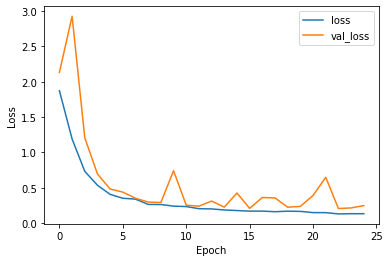

In [41]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])
plt.savefig('metrics_plot.jpeg')
plt.show()

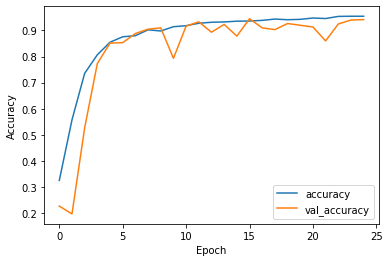

In [47]:
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.savefig('metrics_accuracy_plot.jpeg')
plt.show()

In [42]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [43]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Test set accuracy: 95%


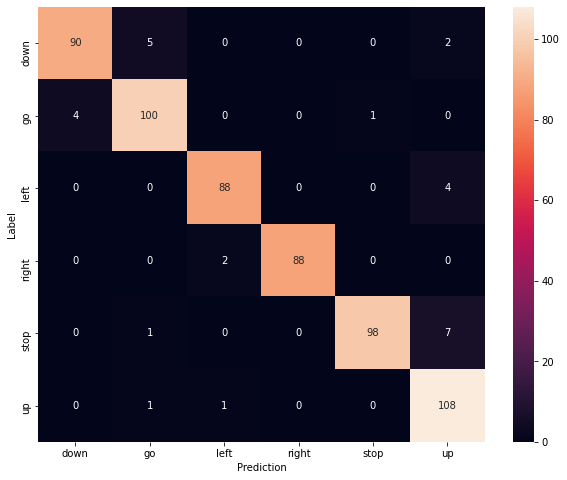

In [44]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')

plt.savefig('confusion_matrix.jpeg')


plt.show()

tf.Tensor([[ 0.65407383  9.525102   -5.5908804  -5.954539   -3.7368457  -0.8194453 ]], shape=(1, 6), dtype=float32)


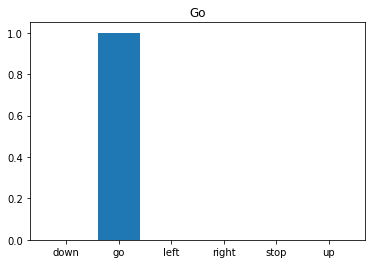

In [45]:
x = data_dir + '/go/0d53e045_nohash_1.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
print(prediction)
x_labels = commands
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Go')
plt.savefig('network_output.jpeg')

plt.show()

display.display(display.Audio(waveform, rate=16000))

In [46]:
model.save("model.h5")